# Data import for given station and given time period. Import also allows for parameter selection in output file.

In [1]:
from viresclient import SwarmRequest
import hapiclient
from hapiclient.util import pythonshell
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000 # Modified Julian date
from math import sqrt
import tqdm

import utils

The objective of this notebook is to download the full input data for a period of time and a given station. This notebook then exports the data to a csv file.

In [2]:
###Define station and time parameters, and OMNI parameters.

### Time parameters
start_date= 1998
end_date=2020

### Observatory parameters
observatory='NGK' 

### Download observatory metadata:
obsmeta = utils.fetch_ground_obs(observatory,'1998-01-01','1998-01-03')
latitude = obsmeta.attrs['Latitude_GEO']
longitude_deg = obsmeta.attrs['Longitude_GEO']
radius = obsmeta.attrs['Radius_GEO']


###OPTIONAL: input radius, latitude,longitude manually
#latitude=55.31
#longitude_deg=356.79 ##longitude is in degrees from Prime Meridian, i.e. 1 degree west is 359 degrees
#radius= 6371


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

In [3]:
###Step 1; Get year data into correct time indexing format


start_date_str= f'{start_date}-01-01'
end_date_str=f'{end_date}-01-01'

year_range=pd.date_range(start_date_str, end_date_str, freq='1YS')

print('list of years to be downloaded:')
print(year_range)

list of years to be downloaded:
DatetimeIndex(['1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')


In [4]:
###Step 2; Download magnetic field model for given station.


CHAOS7 = utils.loadChaosModel(start_date,end_date,latitude,longitude_deg)
CHAOS7

###NOTE: This function assumes constant radius, which is not the case; radius varies according to latitude and height
###from sea level. Change radius= parameter (last parameter in function) to get more accurate.

###Further NOTE: this function does not include the last 24 hours of the period in question. Consider
###changing this if possible.

,B_radius,B_phi,B_theta,B_H
1998-01-01 00:00:00,-45003.735634,355.676092,-18613.382250,18616.780180
1998-01-01 00:01:00,-45003.735702,355.676163,-18613.382255,18616.780186
1998-01-01 00:02:00,-45003.735769,355.676235,-18613.382259,18616.780192
1998-01-01 00:03:00,-45003.735837,355.676306,-18613.382263,18616.780197
1998-01-01 00:04:00,-45003.735904,355.676378,-18613.382267,18616.780203
...,...,...,...,...
2020-12-30 23:56:00,-45848.121978,1365.227373,-18687.930509,18737.731786
2020-12-30 23:57:00,-45848.121978,1365.227373,-18687.930509,18737.731786
2020-12-30 23:58:00,-45848.121978,1365.227373,-18687.930509,18737.731786
2020-12-30 23:59:00,-45848.121978,1365.227373,-18687.930509,18737.731786


In [7]:
###Step 3; loop over years and download observatory data
    
    
##Define start and end of download period for this year
start= start_date_str
end= end_date_str

print('Downloading Observatory data for',observatory,str(start)[:4],'to',str(end)[:4])

obs = utils.fetch_ground_obs(observatory, start, end)#Download obs data

print(obs)

obs = utils.manipulate_obs_data(obs,CHAOS7,option=2)#Manipulate obs data to remove background mag field


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

<xarray.Dataset>
Dimensions:    (Timestamp: 11568960, NEC: 3)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00
  * NEC        (NEC) <U1 'N' 'E' 'C'
Data variables:
    B_NEC      (Timestamp, NEC) float64 1.862e+04 369.2 ... 1.326e+03 4.585e+04
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    51.885256405821096
    Longitude_GEO:   12.675
    Radius_GEO:      6364951.936565544
Manipulating obsvervatory data


<xarray.Dataset>
Dimensions:    (Timestamp: 11568960)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 1998-01-01 ... 2019-12-31T23:59:00
Data variables:
    B_N        (Timestamp) float64 -3.773 -4.174 -4.374 ... 15.56 15.66 15.86
    B_E        (Timestamp) float64 27.4 27.39 27.39 ... -24.61 -24.71 -24.92
    B_C        (Timestamp) float64 19.33 19.43 19.53 ... -41.75 -41.85 -41.85
    B_H        (Timestamp) float64 -2.636 -3.036 -3.237 ... 13.59 13.68 13.87
    dBdt       (Timestamp) float64 nan -0.4004 -0.2003 ... 0.09301 0.1854
    dBdt1      (Timestamp) float64 nan 0.4005 0.2003 ... 0.1413 0.1417 0.2829
Attributes:
    Sources:         ['SW_OPER_AUX_OBSM2__19980101T000000_19980101T235959_010...
    MagneticModels:  []
    AppliedFilters:  []
    Latitude_GEO:    51.885256405821096
    Longitude_GEO:   12.675
    Radius_GEO:      6364951.936565544


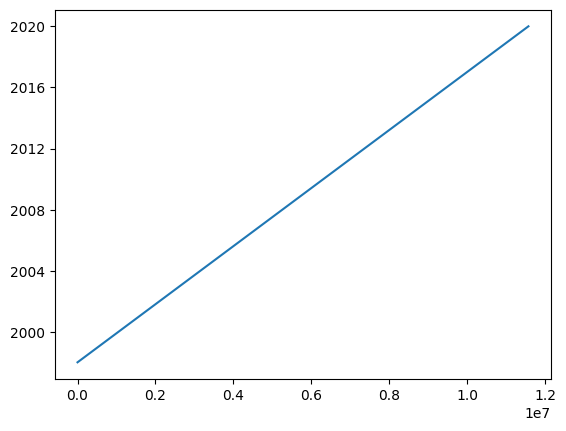

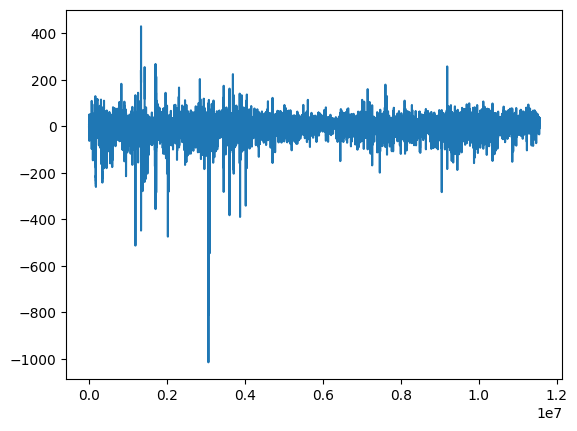

In [8]:
#print(events_tot['B_N'])

print(obs)

plt.plot(obs['Timestamp'])
plt.show()
plt.plot(obs['B_N'])
plt.show()

In [12]:
###Step 4: get current directory and set PATH variable to where data will be saved.

import os

# Get the current working directory
current_path = os.getcwd()

# Print the current working directory
print("Current working directory:", current_path)

#define path to data folder where data will be placed. Print current path if you don't know what it is!
PATH = '/mnt/c/users/s1725621/Documents/PhDCode/Git/dBdtCorrelation/data/'

Current working directory: /mnt/c/Users/s1725621/Documents/PhDCode/Git/dBdtCorrelation/dBdtvsdHdt


In [ ]:
###Step 5: save observatory data.

###Save to netcdf file
##obs.to_netcdf(path = PATH+observatory+str(start)[:4]+str(end)[:4]+'.nc')

###Save to csv file
# Convert xarray Dataset to pandas DataFrame
obf = obs.to_dataframe()

# Save the DataFrame to a CSV file
obf.to_csv(PATH+observatory+str(start)[:4]+str(end)[:4]+'.csv',index=True)

# Loop through observatories and download all into data folder.

In [13]:
###Import list of observatories from csv.
df = pd.read_csv("data/ObsListimo.csv")
print(df['Code'])

0      ABG
1      ABK
2      AIA
3      API
4      ARS
      ... 
117    VSS
118    WIC
119    WNG
120    YAK
121    YKC
Name: Code, Length: 122, dtype: object


In [ ]:
for i in df['Code']:
    try:
        ### Observatory parameters 
        i=str(i)
        
        ### Download observatory metadata:
        obsmetai = utils.fetch_ground_obs(i,'1998-01-01','1998-01-03')
        latitudei = obsmetai.attrs['Latitude_GEO']
        longitude_degi = obsmetai.attrs['Longitude_GEO']
        radiusi = obsmetai.attrs['Radius_GEO']
        
        ###Find model values for this station
        CHAOS7i = utils.loadChaosModel(start_date,end_date,latitudei,longitude_degi)
        
        ###Download data.
        obsi = utils.fetch_ground_obs(i, start, end)#Download obs data
        obsi = utils.manipulate_obs_data(obsi,CHAOS7i)#Manipulate obs data to remove background mag field
        
        ###Save to netcdf file
        ##obs.to_netcdf(path = PATH+observatory+str(start)[:4]+str(end)[:4]+'.nc')
        
        ###Save to csv file
        # Convert xarray Dataset to pandas DataFrame
        obfi = obsi.to_dataframe()
        
        # Save the DataFrame to a CSV file
        obfi.to_csv(PATH+i+str(start)[:4]+str(end)[:4]+'.csv',index=True)
    except:
        continue

#  Data export of dHdt using second method (utils.manipulate_obs_data_dBdt_equals_sqrtdBxdtdBydt)

In [ ]:
###Define station and time parameters, and OMNI parameters.

### Time parameters
start_date= 1998
end_date=2020

### Observatory parameters
observatory='CLF' 

### Download observatory metadata:
obsmeta = utils.fetch_ground_obs(observatory,'1998-01-01','1998-01-03')
latitude = obsmeta.attrs['Latitude_GEO']
longitude_deg = obsmeta.attrs['Longitude_GEO']
radius = obsmeta.attrs['Radius_GEO']


###OPTIONAL: input radius, latitude,longitude manually
#latitude=55.31
#longitude_deg=356.79 ##longitude is in degrees from Prime Meridian, i.e. 1 degree west is 359 degrees
#radius= 6371

In [ ]:
###Step 1; Get year data into correct time indexing format


start_date_str= f'{start_date}-01-01'
end_date_str=f'{end_date}-01-01'

year_range=pd.date_range(start_date_str, end_date_str, freq='1YS')

print('list of years to be downloaded:')
print(year_range)

In [ ]:
###Step 2; Download magnetic field model for given station.


CHAOS7 = utils.loadChaosModel(start_date,end_date,latitude,longitude_deg)
CHAOS7

###NOTE: This function assumes constant radius, which is not the case; radius varies according to latitude and height
###from sea level. Change radius= parameter (last parameter in function) to get more accurate.

###Further NOTE: this function does not include the last 24 hours of the period in question. Consider
###changing this if possible.

In [ ]:
###Step 3; loop over years and download observatory data
    
    
##Define start and end of download period for this year
start= start_date_str
end= end_date_str

print('Downloading Observatory data for',observatory,str(start)[:4],'to',str(end)[:4])

obs = utils.fetch_ground_obs(observatory, start, end)#Download obs data
obs = utils.manipulate_obs_data(obs,CHAOS7, option=2)#Manipulate obs data to remove background mag field

In [ ]:
obs['dbdtdiff']=obs.dBdt1-((obs.dBdt)**2)**0.5

print(obs)
print(np.mean(obs['dbdtdiff']))

In [ ]:
plt.plot(obs['dbdtdiff'])
print(np.mean(obs['dbdtdiff']))

# Loop over observatories and see what the average difference is between the two.

In [20]:
###Import list of observatories from csv.
df = pd.read_csv("data/ObsListimo.csv")
print(df['Code'])

0      ABG
1      ABK
2      AIA
3      API
4      ARS
      ... 
117    VSS
118    WIC
119    WNG
120    YAK
121    YKC
Name: Code, Length: 122, dtype: object


In [ ]:
averagevalues =[]

for i in tqdm.tqdm(df['Code']):
    try:
        row=[]
        ### Observatory parameters 
        i=str(i)
        
        ### Download observatory metadata:
        obsmetai = utils.fetch_ground_obs(i,'1998-01-01','1998-01-03')
        latitudei = obsmetai.attrs['Latitude_GEO']
        longitude_degi = obsmetai.attrs['Longitude_GEO']
        radiusi = obsmetai.attrs['Radius_GEO']
        
        ###Find model values for this station
        CHAOS7i = utils.loadChaosModel(start_date,end_date,latitudei,longitude_degi)
        
        ###Download data.
        obsi = utils.fetch_ground_obs(i, start, end)#Download obs data
        obsi = utils.manipulate_obs_data(obsi,CHAOS7i,option = 2)#Manipulate obs data to remove background mag field
        obsi['dbdtdiff']=obsi.dBdt1-((obsi.dBdt)**2)**0.5
        
        row.append(i)
        row.append(np.mean(obsi['dbdtdiff']))
        row.append(latitudei)
        row.append(longitude_degi)
        
        averagevalues.append(row)
        
    except:
        continue

  0%|                                                                                                                                                                                    | 0/122 [00:00<?, ?it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  0%|                                                                                                                                                                                    | 0/122 [00:16<?, ?it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (234.792MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.494MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.369MB)

Manipulating obsvervatory data


  1%|█▍                                                                                                                                                                       | 1/122 [02:36<5:15:21, 156.38s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  1%|█▍                                                                                                                                                                       | 1/122 [02:52<5:15:21, 156.38s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

  2%|██▊                                                                                                                                                                       | 2/122 [03:19<2:59:01, 89.51s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  2%|████▏                                                                                                                                                                     | 3/122 [03:21<1:38:12, 49.51s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  3%|█████▌                                                                                                                                                                    | 4/122 [03:23<1:00:32, 30.78s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  4%|███████                                                                                                                                                                     | 5/122 [03:25<39:43, 20.37s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  5%|████████▍                                                                                                                                                                   | 6/122 [03:27<27:18, 14.13s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  6%|█████████▊                                                                                                                                                                  | 7/122 [03:29<19:29, 10.17s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  6%|█████████▊                                                                                                                                                                  | 7/122 [03:44<19:29, 10.17s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.894MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

Manipulating obsvervatory data


  7%|███████████▏                                                                                                                                                              | 8/122 [06:01<1:45:30, 55.53s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  7%|███████████▏                                                                                                                                                              | 8/122 [06:20<1:45:30, 55.53s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

In [ ]:
print(averagevalues)

In [ ]:
###Step 5: save observatory data.

###Save to netcdf file
##obs.to_netcdf(path = PATH+observatory+str(start)[:4]+str(end)[:4]+'.nc')

###Save to csv file
# Convert xarray Dataset to pandas DataFrame
obf = averagevalues.to_dataframe()

# Save the DataFrame to a CSV file
obf.to_csv(PATH+o'differencebetweendBdtmethods.csv',index=True)

# Bitwise download of section above.

Clearly above section is difficult to do in one chunk. This code saves to a folder and then checks if the file has already been downloaded. Files are just the data for that one station (stationname, dbdtaverage, lat, long)

In [9]:
import os

###Import list of observatories from csv.
df = pd.read_csv("data/ObsListimo.csv")
print(df['Code'])

0      ABG
1      ABK
2      AIA
3      API
4      ARS
      ... 
117    VSS
118    WIC
119    WNG
120    YAK
121    YKC
Name: Code, Length: 122, dtype: object


In [12]:
averagevalues =[]



for i in tqdm.tqdm(df['Code']):
    if os.path.isfile("data/"+i+".csv"):
        print('station already downloaded.')
        
    else:
        try:
            row=[]
            ### Observatory parameters 
            i=str(i)
            
            ### Download observatory metadata:
            obsmetai = utils.fetch_ground_obs(i,'1998-01-01','1998-01-03')
            latitudei = obsmetai.attrs['Latitude_GEO']
            longitude_degi = obsmetai.attrs['Longitude_GEO']
            radiusi = obsmetai.attrs['Radius_GEO']
            
            ###Find model values for this station
            CHAOS7i = utils.loadChaosModel(start_date,end_date,latitudei,longitude_degi)
            
            ###Download data.
            obsi = utils.fetch_ground_obs(i, start, end)#Download obs data
            obsi = utils.manipulate_obs_data(obsi,CHAOS7i,option = 2)#Manipulate obs data to remove background mag field
            obsi['dbdtdiff']=obsi.dBdt1-((obsi.dBdt)**2)**0.5
            
            row.append(i)
            row.append(float(np.mean(obsi['dbdtdiff'])))
            row.append(latitudei)
            row.append(longitude_degi)
            
            averagevalues.append(row)
            
            row=pd.DataFrame(row)
            
            row.to_csv("data/"+i+".csv")
        except:
            continue

  0%|                                                                                                        | 0/122 [00:00<?, ?it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  0%|                                                                                                        | 0/122 [00:23<?, ?it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (234.792MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.494MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.369MB)

Manipulating obsvervatory data


  1%|▊                                                                                            | 1/122 [03:39<7:22:42, 219.53s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  1%|▊                                                                                            | 1/122 [04:00<7:22:42, 219.53s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.894MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

Manipulating obsvervatory data


  2%|█▌                                                                                           | 2/122 [07:21<7:21:07, 220.57s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  2%|██▎                                                                                          | 3/122 [07:23<3:59:41, 120.85s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  3%|███                                                                                           | 4/122 [07:25<2:25:22, 73.92s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  4%|███▊                                                                                          | 5/122 [07:27<1:33:32, 47.97s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  5%|████▌                                                                                         | 6/122 [07:29<1:02:33, 32.36s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  6%|█████▌                                                                                          | 7/122 [07:31<42:59, 22.43s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  6%|█████▌                                                                                          | 7/122 [07:49<42:59, 22.43s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.894MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

Manipulating obsvervatory data


  7%|██████▏                                                                                       | 8/122 [11:21<2:48:33, 88.72s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  7%|██████▏                                                                                       | 8/122 [11:54<2:48:33, 88.72s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.531MB)

Manipulating obsvervatory data


  7%|██████▊                                                                                      | 9/122 [15:11<4:09:39, 132.56s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

  8%|███████▌                                                                                     | 10/122 [15:13<2:52:24, 92.36s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  8%|███████▌                                                                                     | 10/122 [15:31<2:52:24, 92.36s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (243.107MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (234.953MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (138.391MB)

Manipulating obsvervatory data


  9%|████████▎                                                                                   | 11/122 [18:34<3:52:32, 125.70s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

  9%|████████▎                                                                                   | 11/122 [18:54<3:52:32, 125.70s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.531MB)

Manipulating obsvervatory data


 10%|█████████                                                                                   | 12/122 [22:01<4:35:52, 150.47s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 10%|█████████                                                                                   | 12/122 [22:23<4:35:52, 150.47s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (243.512MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.724MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.369MB)

Manipulating obsvervatory data


 11%|█████████▊                                                                                  | 13/122 [25:33<5:07:06, 169.05s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 11%|██████████▌                                                                                 | 14/122 [25:35<3:33:27, 118.59s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 12%|███████████▍                                                                                 | 15/122 [25:37<2:28:48, 83.44s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.094MB)

 12%|███████████▍                                                                                 | 15/122 [25:56<2:28:48, 83.44s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.494MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.311MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.118MB)

Manipulating obsvervatory data


 13%|████████████                                                                                | 16/122 [29:13<3:37:48, 123.29s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 13%|████████████                                                                                | 16/122 [29:31<3:37:48, 123.29s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (229.354MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (221.782MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.289MB)

Manipulating obsvervatory data


 14%|████████████▊                                                                               | 17/122 [32:36<4:17:52, 147.35s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.004MB)

 15%|█████████████▌                                                                              | 18/122 [32:38<2:59:50, 103.76s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 16%|██████████████▍                                                                              | 19/122 [32:40<2:05:43, 73.24s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 16%|██████████████▍                                                                              | 19/122 [33:05<2:05:43, 73.24s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.289MB)

Manipulating obsvervatory data


 16%|███████████████                                                                             | 20/122 [36:26<3:22:18, 119.00s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 16%|███████████████                                                                             | 20/122 [36:45<3:22:18, 119.00s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.311MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.894MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (166.795MB)

Manipulating obsvervatory data


 17%|███████████████▊                                                                            | 21/122 [40:00<4:08:07, 147.40s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 17%|███████████████▊                                                                            | 21/122 [40:19<4:08:07, 147.40s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.805MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.531MB)

Manipulating obsvervatory data


 18%|████████████████▌                                                                           | 22/122 [43:32<4:38:03, 166.84s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 19%|█████████████████▎                                                                          | 23/122 [43:35<3:14:02, 117.60s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 20%|██████████████████▎                                                                          | 24/122 [43:37<2:15:40, 83.06s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 20%|███████████████████                                                                          | 25/122 [43:40<1:35:06, 58.83s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 21%|███████████████████▊                                                                         | 26/122 [43:42<1:07:02, 41.90s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 22%|█████████████████████                                                                          | 27/122 [43:45<47:40, 30.11s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 23%|█████████████████████▊                                                                         | 28/122 [43:47<34:18, 21.90s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 24%|██████████████████████▌                                                                        | 29/122 [43:50<24:52, 16.05s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 25%|███████████████████████▎                                                                       | 30/122 [43:52<18:20, 11.96s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 25%|████████████████████████▏                                                                      | 31/122 [43:55<13:54,  9.17s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 25%|████████████████████████▏                                                                      | 31/122 [44:17<13:54,  9.17s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.531MB)

Manipulating obsvervatory data


 26%|████████████████████████▍                                                                    | 32/122 [47:36<1:49:16, 72.85s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 26%|████████████████████████▍                                                                    | 32/122 [47:59<1:49:16, 72.85s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.894MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.575MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (160.784MB)

Manipulating obsvervatory data


 27%|████████████████████████▉                                                                   | 33/122 [51:20<2:55:26, 118.27s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 27%|████████████████████████▉                                                                   | 33/122 [51:41<2:55:26, 118.27s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.907MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (243.763MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (154.522MB)

Manipulating obsvervatory data


 28%|█████████████████████████▋                                                                  | 34/122 [54:53<3:34:52, 146.50s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 28%|█████████████████████████▋                                                                  | 34/122 [55:13<3:34:52, 146.50s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.494MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.805MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

Manipulating obsvervatory data


 29%|██████████████████████████▍                                                                 | 35/122 [58:40<4:07:41, 170.82s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 29%|██████████████████████████▍                                                                 | 35/122 [59:02<4:07:41, 170.82s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (239.977MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.562MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (166.795MB)

Manipulating obsvervatory data


 30%|██████████████████████████▌                                                               | 36/122 [1:02:13<4:22:54, 183.43s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 30%|██████████████████████████▌                                                               | 36/122 [1:02:38<4:22:54, 183.43s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

Manipulating obsvervatory data


 30%|███████████████████████████▎                                                              | 37/122 [1:06:00<4:38:27, 196.55s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 31%|████████████████████████████                                                              | 38/122 [1:06:02<3:13:26, 138.17s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 32%|█████████████████████████████                                                              | 39/122 [1:06:04<2:14:36, 97.31s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 32%|█████████████████████████████                                                              | 39/122 [1:06:25<2:14:36, 97.31s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (186.632MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (143.003MB)

Manipulating obsvervatory data


 33%|█████████████████████████████▌                                                            | 40/122 [1:09:02<2:45:46, 121.30s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 34%|██████████████████████████████▌                                                            | 41/122 [1:09:04<1:55:26, 85.52s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 34%|██████████████████████████████▌                                                            | 41/122 [1:09:25<1:55:26, 85.52s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (240.883MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (245.656MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.037MB)

Manipulating obsvervatory data


 34%|██████████████████████████████▉                                                           | 42/122 [1:12:38<2:45:37, 124.21s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 34%|██████████████████████████████▉                                                           | 42/122 [1:13:01<2:45:37, 124.21s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (231.822MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (236.191MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (158.641MB)

Manipulating obsvervatory data


 35%|███████████████████████████████▋                                                          | 43/122 [1:16:08<3:17:27, 149.96s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 35%|███████████████████████████████▋                                                          | 43/122 [1:16:27<3:17:27, 149.96s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.531MB)

Manipulating obsvervatory data


 36%|████████████████████████████████▍                                                         | 44/122 [1:19:31<3:35:43, 165.94s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 37%|█████████████████████████████████▏                                                        | 45/122 [1:19:33<2:29:50, 116.76s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 37%|█████████████████████████████████▏                                                        | 45/122 [1:19:58<2:29:50, 116.76s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.45MB)

Manipulating obsvervatory data


 38%|█████████████████████████████████▉                                                        | 46/122 [1:23:20<3:09:27, 149.57s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 38%|█████████████████████████████████▉                                                        | 46/122 [1:23:43<3:09:27, 149.57s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.894MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (165.557MB)

Manipulating obsvervatory data


 39%|██████████████████████████████████▋                                                       | 47/122 [1:27:22<3:41:42, 177.37s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 39%|██████████████████████████████████▋                                                       | 47/122 [1:27:45<3:41:42, 177.37s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (244.75MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.311MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (167.289MB)

Manipulating obsvervatory data


 39%|███████████████████████████████████▍                                                      | 48/122 [1:30:53<3:51:15, 187.50s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.174MB)

 39%|███████████████████████████████████▍                                                      | 48/122 [1:31:16<3:51:15, 187.50s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (246.975MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [3/3] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (60.759MB)

Manipulating obsvervatory data


 40%|████████████████████████████████████▏                                                     | 49/122 [1:34:06<3:50:10, 189.18s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 41%|████████████████████████████████████▉                                                     | 50/122 [1:34:08<2:39:38, 133.03s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 42%|██████████████████████████████████████                                                     | 51/122 [1:34:10<1:50:53, 93.71s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 43%|██████████████████████████████████████▊                                                    | 52/122 [1:34:11<1:16:45, 65.79s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 43%|████████████████████████████████████████▍                                                    | 53/122 [1:34:12<53:12, 46.27s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 44%|█████████████████████████████████████████▏                                                   | 54/122 [1:34:12<37:01, 32.67s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 45%|█████████████████████████████████████████▉                                                   | 55/122 [1:34:13<25:42, 23.02s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 46%|██████████████████████████████████████████▋                                                  | 56/122 [1:34:13<17:52, 16.26s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 47%|███████████████████████████████████████████▍                                                 | 57/122 [1:34:14<12:28, 11.52s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 48%|████████████████████████████████████████████▏                                                | 58/122 [1:34:14<08:45,  8.20s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 48%|████████████████████████████████████████████▉                                                | 59/122 [1:34:15<06:10,  5.88s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 49%|█████████████████████████████████████████████▋                                               | 60/122 [1:34:15<04:23,  4.24s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 50%|██████████████████████████████████████████████▌                                              | 61/122 [1:34:15<03:10,  3.12s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 51%|███████████████████████████████████████████████▎                                             | 62/122 [1:34:16<02:19,  2.33s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 52%|████████████████████████████████████████████████                                             | 63/122 [1:34:17<01:45,  1.78s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 52%|████████████████████████████████████████████████▊                                            | 64/122 [1:34:17<01:21,  1.40s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 53%|█████████████████████████████████████████████████▌                                           | 65/122 [1:34:17<01:02,  1.10s/it]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 54%|██████████████████████████████████████████████████▎                                          | 66/122 [1:34:18<00:51,  1.09it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 55%|███████████████████████████████████████████████████                                          | 67/122 [1:34:18<00:43,  1.27it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 56%|███████████████████████████████████████████████████▊                                         | 68/122 [1:34:19<00:37,  1.43it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 57%|████████████████████████████████████████████████████▌                                        | 69/122 [1:34:19<00:32,  1.63it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 57%|█████████████████████████████████████████████████████▎                                       | 70/122 [1:34:20<00:30,  1.72it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 58%|██████████████████████████████████████████████████████                                       | 71/122 [1:34:20<00:27,  1.86it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 59%|██████████████████████████████████████████████████████▉                                      | 72/122 [1:34:22<00:37,  1.32it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 60%|███████████████████████████████████████████████████████▋                                     | 73/122 [1:34:22<00:39,  1.23it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 61%|████████████████████████████████████████████████████████▍                                    | 74/122 [1:34:23<00:34,  1.38it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 61%|█████████████████████████████████████████████████████████▏                                   | 75/122 [1:34:23<00:29,  1.58it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 62%|█████████████████████████████████████████████████████████▉                                   | 76/122 [1:34:24<00:26,  1.71it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 63%|██████████████████████████████████████████████████████████▋                                  | 77/122 [1:34:24<00:24,  1.87it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 64%|███████████████████████████████████████████████████████████▍                                 | 78/122 [1:34:25<00:22,  1.94it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 65%|████████████████████████████████████████████████████████████▏                                | 79/122 [1:34:25<00:21,  2.04it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 66%|████████████████████████████████████████████████████████████▉                                | 80/122 [1:34:26<00:20,  2.08it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 66%|█████████████████████████████████████████████████████████████▋                               | 81/122 [1:34:26<00:19,  2.14it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 67%|██████████████████████████████████████████████████████████████▌                              | 82/122 [1:34:27<00:19,  2.08it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 68%|███████████████████████████████████████████████████████████████▎                             | 83/122 [1:34:27<00:18,  2.15it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 69%|████████████████████████████████████████████████████████████████                             | 84/122 [1:34:27<00:17,  2.16it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 70%|████████████████████████████████████████████████████████████████▊                            | 85/122 [1:34:28<00:17,  2.15it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 70%|█████████████████████████████████████████████████████████████████▌                           | 86/122 [1:34:28<00:16,  2.21it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 71%|██████████████████████████████████████████████████████████████████▎                          | 87/122 [1:34:29<00:16,  2.13it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 72%|███████████████████████████████████████████████████████████████████                          | 88/122 [1:34:29<00:15,  2.18it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 73%|███████████████████████████████████████████████████████████████████▊                         | 89/122 [1:34:30<00:15,  2.16it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 74%|████████████████████████████████████████████████████████████████████▌                        | 90/122 [1:34:30<00:14,  2.16it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 75%|█████████████████████████████████████████████████████████████████████▎                       | 91/122 [1:34:31<00:17,  1.74it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 75%|██████████████████████████████████████████████████████████████████████▏                      | 92/122 [1:34:32<00:19,  1.56it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 76%|██████████████████████████████████████████████████████████████████████▉                      | 93/122 [1:34:33<00:21,  1.32it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 77%|███████████████████████████████████████████████████████████████████████▋                     | 94/122 [1:34:33<00:18,  1.49it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 78%|████████████████████████████████████████████████████████████████████████▍                    | 95/122 [1:34:34<00:16,  1.61it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 96/122 [1:34:34<00:14,  1.79it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 97/122 [1:34:35<00:13,  1.86it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 98/122 [1:34:35<00:12,  1.91it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 99/122 [1:34:36<00:11,  1.95it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 82%|███████████████████████████████████████████████████████████████████████████▍                | 100/122 [1:34:36<00:11,  1.97it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 83%|████████████████████████████████████████████████████████████████████████████▏               | 101/122 [1:34:37<00:10,  2.00it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 84%|████████████████████████████████████████████████████████████████████████████▉               | 102/122 [1:34:37<00:09,  2.07it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 85%|██████████████████████████████████████████████████████████████████████████████▍             | 104/122 [1:34:38<00:07,  2.45it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 86%|███████████████████████████████████████████████████████████████████████████████▏            | 105/122 [1:34:38<00:07,  2.42it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 87%|███████████████████████████████████████████████████████████████████████████████▉            | 106/122 [1:34:39<00:06,  2.32it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 88%|████████████████████████████████████████████████████████████████████████████████▋           | 107/122 [1:34:39<00:06,  2.34it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 89%|█████████████████████████████████████████████████████████████████████████████████▍          | 108/122 [1:34:40<00:06,  2.27it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 89%|██████████████████████████████████████████████████████████████████████████████████▏         | 109/122 [1:34:40<00:05,  2.27it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 111/122 [1:34:41<00:05,  1.97it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 92%|████████████████████████████████████████████████████████████████████████████████████▍       | 112/122 [1:34:43<00:06,  1.62it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 93%|█████████████████████████████████████████████████████████████████████████████████████▏      | 113/122 [1:34:43<00:06,  1.39it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 114/122 [1:34:44<00:05,  1.54it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 94%|██████████████████████████████████████████████████████████████████████████████████████▋     | 115/122 [1:34:44<00:04,  1.66it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 116/122 [1:34:45<00:03,  1.77it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 117/122 [1:34:45<00:02,  1.86it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 97%|████████████████████████████████████████████████████████████████████████████████████████▉   | 118/122 [1:34:45<00:02,  1.92it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 98%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 119/122 [1:34:46<00:01,  2.02it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 98%|██████████████████████████████████████████████████████████████████████████████████████████▍ | 120/122 [1:34:46<00:00,  2.07it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

 99%|███████████████████████████████████████████████████████████████████████████████████████████▏| 121/122 [1:34:47<00:00,  2.10it/s]


Accessing INTERMAGNET and/or WDC data
Check usage terms at ftp://ftp.nerc-murchison.ac.uk/geomag/Swarm/AUX_OBS/minute/README



Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

100%|████████████████████████████████████████████████████████████████████████████████████████████| 122/122 [1:34:47<00:00, 46.62s/it]


In [13]:
for i in tqdm.tqdm(df['Code']):
    if os.path.isfile("data/"+i+".csv"):
        dfi=pd.read_csv("data/"+i+".csv")
        print(dfi)
        dfi=dfi.to_numpy()
        print(dfi)
        listofstationobs.append(dfi)
    else:
        continue

  0%|                                                                                                        | 0/122 [00:00<?, ?it/s]

   Unnamed: 0                    0
0           0                  ABG
1           1  0.08794706429562191
2           2   18.503862645140103
3           3                72.87
[[0 'ABG']
 [1 '0.08794706429562191']
 [2 '18.503862645140103']
 [3 '72.87']]


NameError: name 'listofstationobs' is not defined

In [ ]:
for i in listofstationobs:
    row=[]
    row.append(i[0],i[1],i[2])
    print(row)